In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import csv
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras import layers

Using TensorFlow backend.


In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth spectral_contrast rolloff zero_crossing_rate tempo'
for i in range(1, 14):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('genres.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spec_cont = librosa.feature.spectral_contrast(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        tempo = librosa.beat.tempo(y=y, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_cont)} {np.mean(rolloff)} {np.mean(zcr)} {tempo[0]}'    
        for i, e in enumerate(mfcc):
            if i==13: 
                break
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('genres.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [3]:
data = pd.read_csv('genres.csv')
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tempo,mfcc1,...,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,label
0,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,20.530733,3806.485316,0.083066,123.046875,-113.596748,...,-6.376458,18.618876,-13.697912,15.344631,-12.285267,10.980493,-8.324325,8.810669,-3.667369,blues
1,blues.00001.wav,0.340983,0.095918,1529.835316,2038.617579,20.676334,3548.820207,0.056044,107.666016,-207.556793,...,2.916037,21.523726,-8.554704,23.358671,-10.103617,11.903745,-5.560388,5.376803,-2.239120,blues
2,blues.00002.wav,0.363603,0.175573,1552.481958,1747.165985,22.197265,3040.514948,0.076301,161.499023,-90.754387,...,-13.987036,25.754759,-13.649587,11.629271,-11.780589,9.706443,-13.123111,5.789265,-8.905224,blues
3,blues.00003.wav,0.404779,0.141191,1070.119953,1596.333948,21.428764,2185.028454,0.033309,172.265625,-199.431152,...,1.754462,14.238345,-4.830883,9.297966,-0.757742,8.149013,-3.196314,6.087676,-2.476421,blues
4,blues.00004.wav,0.308590,0.091563,1835.494603,1748.362448,21.467739,3580.945013,0.101500,135.999178,-160.266037,...,-32.489265,10.864513,-23.357929,0.503118,-11.805832,1.206806,-13.083821,-2.806384,-6.934123,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,0.351991,0.079469,2008.581132,2106.617024,22.988721,4254.215942,0.089267,103.359375,-153.632309,...,-7.490499,19.731216,-16.481268,18.078421,-22.209015,15.402502,-12.380283,12.350817,-12.306271,rock
996,rock.00096.wav,0.398653,0.076452,2006.051164,2068.327905,22.673572,4147.374921,0.097659,117.453835,-142.424210,...,-8.375370,22.869041,-18.311548,20.091076,-22.100393,10.800343,-12.982494,14.065345,-16.394691,rock
997,rock.00097.wav,0.432103,0.081617,2077.190361,1926.989678,22.320874,4030.767293,0.121824,129.199219,-125.031311,...,-13.480977,21.755636,-12.418756,20.130630,-18.361841,10.113328,-16.048916,10.481961,-17.951916,rock
998,rock.00098.wav,0.362349,0.083888,1398.672358,1818.148469,22.499462,3014.740104,0.048731,112.347147,-224.972305,...,10.443339,20.611948,-10.250206,15.563110,-8.238567,12.796228,-9.000730,7.683083,-10.071787,rock


In [4]:
data = data.drop(['filename'],axis=1)

In [5]:
rand = 50

In [6]:
genre_list = pd.DataFrame(data.iloc[:, -1])
print(genre_list.shape)
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

print(X_train.shape)
print(y_test.shape)

(1000, 1)
(800, 21)
(200,)


c:\users\hp\venv\iktim\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
X2_train = X_train[:, -13:]
X2_test = X_test[:, -13:]
print(X2_train.shape)
print(X2_test.shape)
print(X_train[0, :])
print(X2_train[0, :])

(800, 13)
(200, 13)
[ 3.48869831  3.35177625  3.11989239  1.14305732 -3.21746063  1.9392381
  3.74484569  0.39355086  1.86168363 -1.9847955   0.04443676 -1.90639276
  0.83002902 -0.93707221  0.82923402 -0.81174159  1.60378693 -0.74318154
  0.80014623 -0.72417476  1.04140373]
[ 1.86168363 -1.9847955   0.04443676 -1.90639276  0.83002902 -0.93707221
  0.82923402 -0.81174159  1.60378693 -0.74318154  0.80014623 -0.72417476
  1.04140373]


In [8]:
names = ['LogisticR', 'NaiveBayes', 'KNN', 'RandomForest']
classifiers = [LogisticRegression(random_state=rand, C=30, max_iter=50), 
               GaussianNB(), KNeighborsClassifier(5), 
               RandomForestClassifier(n_estimators=500 ,max_depth=20, random_state=rand)]

In [9]:
pred1 = []
acc1 = []
f11 = []
for clf in classifiers:
    clf.fit(X_train, y_train)
    pred1.append(clf.predict(X_test))
    acc1.append(accuracy_score(y_test, pred1[-1]))
    f11.append(f1_score(y_test, pred1[-1], average='weighted'))

c:\users\hp\venv\iktim\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


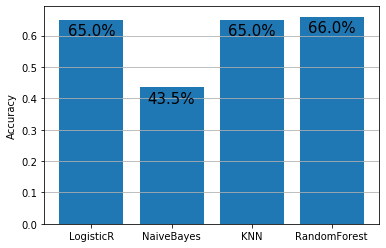

In [12]:
y_pos = np.arange(len(classifiers))
plt.bar(y_pos, acc1)
plt.xticks(y_pos, names)
for y_v, acc_v in zip(y_pos, acc1):
    plt.text(y_v, acc_v-0.05, str(np.around(acc_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.savefig('Accuracy_1.png')

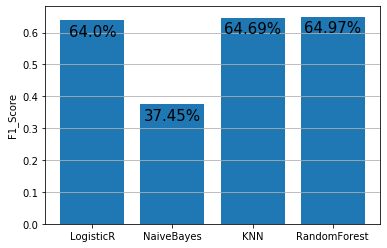

In [13]:
plt.bar(y_pos, f11)
plt.xticks(y_pos, names)
for y_v, f1_v in zip(y_pos, f11):
    plt.text(y_v, f1_v-0.05, str(np.around(f1_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('F1_Score')
plt.grid(axis='y')
plt.savefig('F1_score_1')

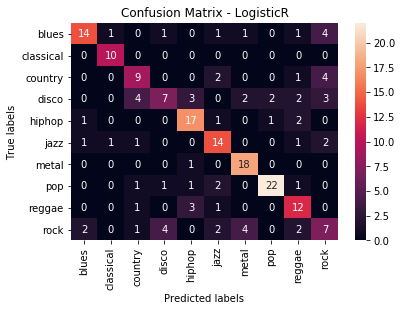

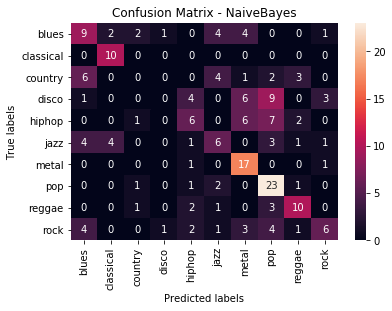

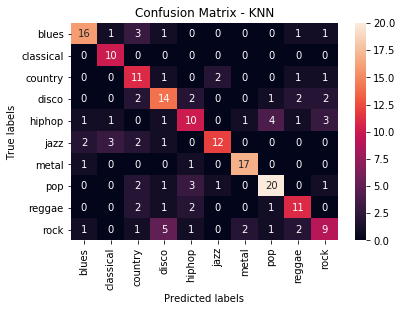

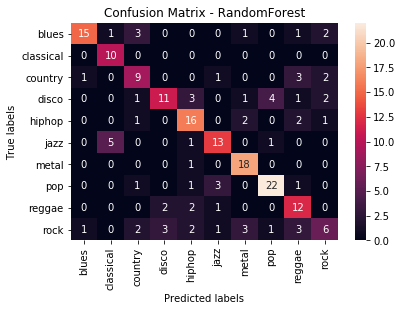

In [26]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for i, pr in enumerate(pred1):
    cm = confusion_matrix(y_test, pr)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, xticklabels=genres, yticklabels=genres)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix - '+names[i])
    plt.savefig('CM_1_'+names[i]+'.png', bbox_inches='tight')
    plt.show()

In [17]:
pred2 = []
acc2 = []
f12 = []
for clf in classifiers:
    clf.fit(X2_train, y_train)
    pred2.append(clf.predict(X2_test))
    acc2.append(accuracy_score(y_test, pred2[-1]))
    f12.append(f1_score(y_test, pred2[-1], average='weighted'))

c:\users\hp\venv\iktim\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


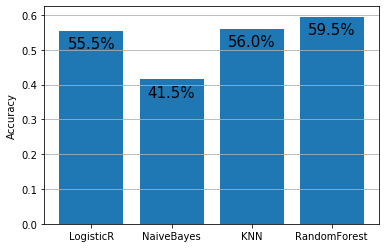

In [18]:
plt.bar(y_pos, acc2)
plt.xticks(y_pos, names)
for y_v, acc_v in zip(y_pos, acc2):
    plt.text(y_v, acc_v-0.05, str(np.around(acc_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.savefig('Accuracy_2.png')

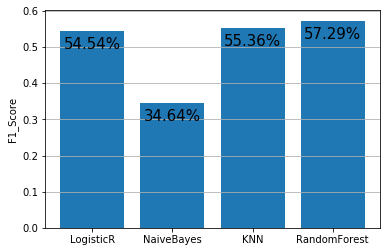

In [19]:
y_pos = range(len(classifiers))
plt.bar(y_pos, f12)
plt.xticks(y_pos, names)
for y_v, f1_v in zip(y_pos, f12):
    plt.text(y_v, f1_v-0.05, str(np.around(f1_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('F1_Score')
plt.grid(axis='y')
plt.savefig('F1_score_2')

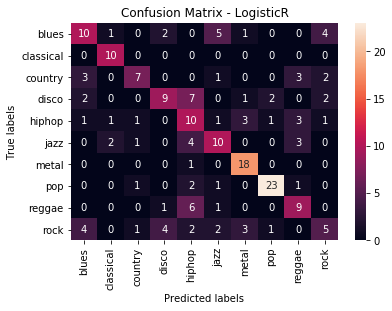

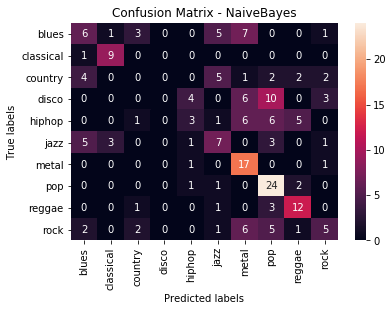

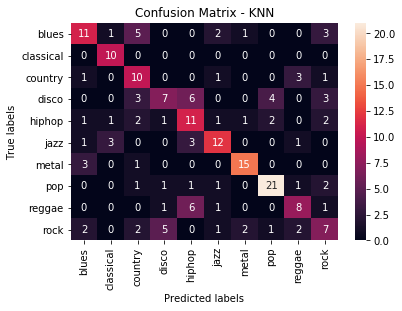

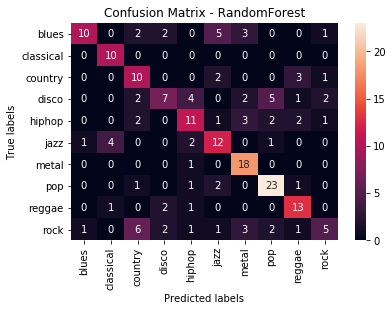

In [25]:
for i, pr in enumerate(pred2):
    cm = confusion_matrix(y_test, pr)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, xticklabels=genres, yticklabels=genres)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix - '+names[i])
    plt.savefig('CM_2_'+names[i]+'.png', bbox_inches='tight')
    plt.show()

In [22]:
svc = SVC(random_state=rand)
param = [{'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}, 
         {'kernel': ['rbf'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000], 
         'gamma': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]}]
clf = GridSearchCV(svc, param, scoring = ['accuracy', 'f1_weighted'], refit = 'f1_weighted')
result = clf.fit(X_train, y_train)

In [23]:
result_tbl = pd.DataFrame(result.cv_results_)
result_tbl

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_accuracy,split1_test_accuracy,...,std_test_accuracy,rank_test_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.023201,4.400392e-03,0.006000,1.095366e-03,0.01,linear,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.42500,0.42500,...,0.026693,69,0.384450,0.390205,0.449313,0.453211,0.437173,0.422870,0.029555,69
1,0.018801,1.469814e-03,0.005200,3.999711e-04,0.03,linear,NaN,"{'C': 0.03, 'kernel': 'linear'}",0.50625,0.53125,...,0.031375,61,0.493151,0.518573,0.534273,0.585218,0.529122,0.532068,0.030117,61
2,0.019001,9.536743e-08,0.004600,4.899209e-04,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.54375,0.57500,...,0.036099,55,0.537451,0.561071,0.632951,0.623788,0.582505,0.587553,0.036362,55
3,0.024001,1.673512e-03,0.004800,3.999710e-04,0.3,linear,NaN,"{'C': 0.3, 'kernel': 'linear'}",0.58750,0.63750,...,0.022500,50,0.578952,0.628585,0.619397,0.612150,0.588888,0.605594,0.018713,50
4,0.037402,3.262206e-03,0.004800,4.000902e-04,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.62500,0.63750,...,0.033541,40,0.615588,0.623215,0.627404,0.653066,0.569782,0.617811,0.027114,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.040202,2.039787e-03,0.008201,7.484939e-04,3000,rbf,0.03,"{'C': 3000, 'gamma': 0.03, 'kernel': 'rbf'}",0.67500,0.65625,...,0.015512,13,0.665681,0.652691,0.648481,0.638743,0.680495,0.657218,0.014502,13
128,0.052403,1.854898e-03,0.008400,4.899793e-04,3000,rbf,0.1,"{'C': 3000, 'gamma': 0.1, 'kernel': 'rbf'}",0.68125,0.70000,...,0.017410,1,0.669033,0.701320,0.692071,0.644817,0.685398,0.678528,0.019883,2
129,0.063604,1.624778e-03,0.008000,1.784161e-07,3000,rbf,0.3,"{'C': 3000, 'gamma': 0.3, 'kernel': 'rbf'}",0.64375,0.68125,...,0.029155,32,0.642883,0.688388,0.596861,0.617196,0.632187,0.635503,0.030629,27
130,0.070604,2.245019e-03,0.009001,1.264932e-03,3000,rbf,1,"{'C': 3000, 'gamma': 1, 'kernel': 'rbf'}",0.40000,0.38750,...,0.020156,77,0.424472,0.426124,0.457301,0.363767,0.417642,0.417861,0.030311,70


In [24]:
print(result.best_estimator_)
print(result.best_score_)
print(result.best_params_)

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=50, shrinking=True, tol=0.001,
    verbose=False)
0.678702921983154
{'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}


In [27]:
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
print(acc)
print(f1)
print(confusion_matrix(y_test, pred))

0.7
0.6970043461963324
[[17  1  2  0  0  1  1  0  0  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  0 10  1  0  2  0  0  1  1]
 [ 0  0  3 11  6  0  1  0  1  1]
 [ 1  0  0  0 16  0  1  0  3  1]
 [ 0  4  1  0  0 14  0  1  0  0]
 [ 0  0  0  0  1  0 16  0  2  0]
 [ 0  0  0  0  1  1  0 23  2  1]
 [ 0  0  1  1  1  1  0  0 13  0]
 [ 2  0  1  2  2  0  2  1  2 10]]


In [40]:
svm = SVC(C=20, gamma=0.1, kernel='rbf', random_state=rand)
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, pred_svm)
f1_svm = f1_score(y_test, pred, average='weighted')
print(acc_svm)
print(f1_svm)
print(confusion_matrix(y_test, pred_svm))

0.72
0.6970043461963324
[[18  1  1  0  0  1  1  0  0  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  0 10  1  0  3  0  0  1  0]
 [ 0  0  3 11  5  0  0  0  2  2]
 [ 1  0  0  0 16  0  1  0  3  1]
 [ 1  3  0  0  0 16  0  0  0  0]
 [ 1  0  0  0  1  0 16  0  1  0]
 [ 0  0  1  0  1  1  0 23  1  1]
 [ 0  0  1  2  1  0  0  0 13  0]
 [ 2  0  1  2  2  0  1  1  2 11]]


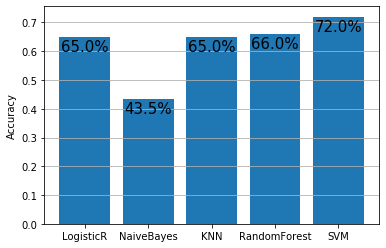

In [43]:
y_pos = np.arange(len(classifiers)+1)
plt.bar(y_pos, acc1+[acc_svm])
plt.xticks(y_pos, names+['SVM'])
for y_v, acc_v in zip(y_pos, acc1+[acc_svm]):
    plt.text(y_v, acc_v-0.05, str(np.around(acc_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.savefig('Accuracy_1_svm.png')

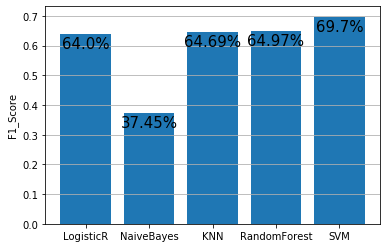

In [106]:
plt.bar(y_pos, f11+[f1_svm])
plt.xticks(y_pos, names+['SVM'])
for y_v, f1_v in zip(y_pos, f11+[f1_svm]):
    plt.text(y_v, f1_v-0.05, str(np.around(f1_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('F1_Score')
plt.grid(axis='y')
plt.savefig('F1_score_1_svm.png')

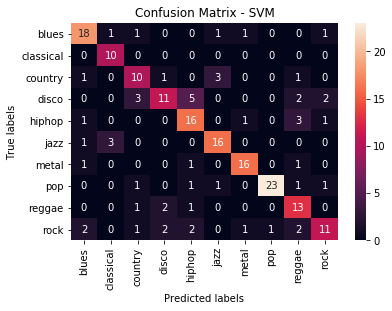

In [45]:
cm = confusion_matrix(y_test, pred_svm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, xticklabels=genres, yticklabels=genres)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix - SVM')
plt.savefig('CM_1_svm.png', bbox_inches='tight')
plt.show()

In [46]:
result2 = clf.fit(X2_train, y_train)

In [47]:
result2_tbl = pd.DataFrame(result2.cv_results_)
result2_tbl

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_accuracy,split1_test_accuracy,...,std_test_accuracy,rank_test_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.101206,0.121337,0.012001,1.303909e-02,0.01,linear,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.39375,0.38750,...,0.012870,78,0.343867,0.313965,0.356351,0.331452,0.331465,0.335420,0.014151,77
1,0.071804,0.080400,0.006800,2.400200e-03,0.03,linear,NaN,"{'C': 0.03, 'kernel': 'linear'}",0.40000,0.46875,...,0.042131,70,0.370200,0.449776,0.451048,0.505519,0.466237,0.448556,0.044056,70
2,0.095405,0.073103,0.005200,7.483537e-04,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.47500,0.46250,...,0.040389,58,0.461272,0.448918,0.516876,0.558375,0.507757,0.498640,0.039630,65
3,0.047203,0.033110,0.004200,4.000425e-04,0.3,linear,NaN,"{'C': 0.3, 'kernel': 'linear'}",0.47500,0.47500,...,0.042131,52,0.467570,0.470309,0.562892,0.540034,0.518182,0.511798,0.037752,53
4,0.070604,0.055877,0.005000,1.549204e-03,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.47500,0.51875,...,0.030974,41,0.474491,0.509053,0.555808,0.522857,0.546369,0.521716,0.028851,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.061604,0.001960,0.006600,8.000612e-04,3000,rbf,0.03,"{'C': 3000, 'gamma': 0.03, 'kernel': 'rbf'}",0.53125,0.55000,...,0.007289,34,0.528001,0.543186,0.530258,0.537417,0.549834,0.537739,0.008085,34
128,0.043003,0.002608,0.007400,7.999420e-04,3000,rbf,0.1,"{'C': 3000, 'gamma': 0.1, 'kernel': 'rbf'}",0.56250,0.55625,...,0.033307,6,0.559844,0.555683,0.636450,0.549774,0.584108,0.577172,0.031858,6
129,0.053603,0.000800,0.007000,1.784161e-07,3000,rbf,0.3,"{'C': 3000, 'gamma': 0.3, 'kernel': 'rbf'}",0.55625,0.58750,...,0.024174,15,0.543369,0.585026,0.602721,0.527643,0.559733,0.563699,0.027227,16
130,0.058403,0.001960,0.008601,1.019945e-03,3000,rbf,1,"{'C': 3000, 'gamma': 1, 'kernel': 'rbf'}",0.49375,0.50625,...,0.030000,62,0.486711,0.528974,0.562928,0.484504,0.462347,0.505093,0.036067,57


In [48]:
print(result2.best_estimator_)
print(result2.best_score_)
print(result2.best_params_)

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=50, shrinking=True, tol=0.001,
    verbose=False)
0.5950423616661248
{'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}


In [49]:
pred2.append(clf.predict(X2_test))
acc2.append(accuracy_score(y_test, pred2[-1]))
f12.append(f1_score(y_test, pred2[-1], average='weighted'))

[0.555, 0.415, 0.56, 0.595, 0.625]


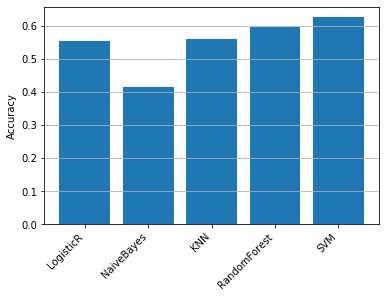

In [50]:
plt.bar(y_pos, acc2)
plt.xticks(y_pos, names+['SVM'], rotation=45, horizontalalignment='right')
plt.ylabel('Accuracy')
plt.grid(axis='y')
print(acc2)

[0.5453811365101779, 0.34635631372416426, 0.5535937085409853, 0.5729118374466082, 0.6181732595749624]


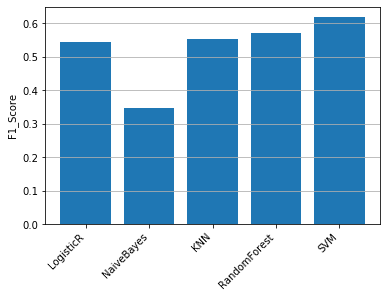

In [51]:
plt.bar(y_pos, f12)
plt.xticks(y_pos, names+['SVM'], rotation=45, horizontalalignment='right')
plt.ylabel('F1_Score')
plt.grid(axis='y')
print(f12)

In [52]:
print('SVM')
print(confusion_matrix(y_test, pred2[-1]))

SVM
[[13  1  1  0  1  3  1  0  0  3]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 2  0  9  1  0  1  0  0  2  1]
 [ 0  0  3  8  7  0  1  3  0  1]
 [ 0  0  1  1 11  1  3  1  3  1]
 [ 0  3  1  1  3 12  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0]
 [ 0  0  0  0  1  0  0 23  2  2]
 [ 0  0  0  1  5  1  0  0 10  0]
 [ 2  0  1  3  1  2  2  0  1 10]]


In [98]:
model = Sequential()
model.add(layers.Dense(512, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [99]:
history = model.fit(X_train, y_train, epochs=20, batch_size=20, validation_split=0.1)

Train on 720 samples, validate on 80 samples
Epoch 1/20
720/720 [==============================] - 1s 1ms/step - loss: 1.8354 - accuracy: 0.3417 - val_loss: 1.4712 - val_accuracy: 0.5000
Epoch 2/20
720/720 [==============================] - 0s 438us/step - loss: 1.3480 - accuracy: 0.4944 - val_loss: 1.3755 - val_accuracy: 0.5375
Epoch 3/20
720/720 [==============================] - 0s 447us/step - loss: 1.1579 - accuracy: 0.5917 - val_loss: 1.2513 - val_accuracy: 0.5500
Epoch 4/20
720/720 [==============================] - 0s 472us/step - loss: 1.0303 - accuracy: 0.6306 - val_loss: 1.3106 - val_accuracy: 0.5625
Epoch 5/20
720/720 [==============================] - 0s 468us/step - loss: 0.9707 - accuracy: 0.6611 - val_loss: 1.2597 - val_accuracy: 0.5500
Epoch 6/20
720/720 [==============================] - 0s 496us/step - loss: 0.8931 - accuracy: 0.6778 - val_loss: 1.1184 - val_accuracy: 0.6500
Epoch 7/20
720/720 [==============================] - 0s 463us/step - loss: 0.7799 - accuracy

In [100]:
result = model.evaluate(X_test, y_test)
print(result)

200/200 [==============================] - 0s 120us/step
[1.332447696328163, 0.6850000023841858]


In [101]:
predd = model.predict(X_test)
pred = []
for p in predd:
    pred.append(np.argmax(p))
acc_nn = accuracy_score(y_test, pred)
f1_nn = f1_score(y_test, pred, average='weighted')
print(acc_nn)
print(f1_nn)
print(confusion_matrix(y_test, pred))

0.685
0.6787669294100194
[[18  0  1  0  0  1  1  0  0  2]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 12  1  0  2  0  0  1  0]
 [ 1  0  1 10  2  0  2  3  2  2]
 [ 2  1  0  0 15  0  2  0  2  0]
 [ 0  1  0  1  1 15  0  0  0  2]
 [ 0  0  0  0  1  0 18  0  0  0]
 [ 1  0  2  1  1  2  0 20  0  1]
 [ 0  0  1  2  4  0  0  0 10  0]
 [ 3  0  1  6  2  0  1  0  0  9]]


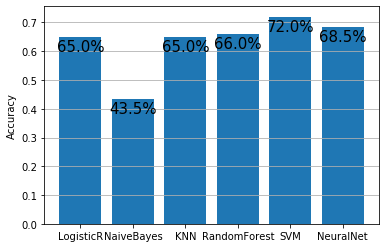

In [102]:
y_pos = np.arange(len(classifiers)+2)
plt.bar(y_pos, acc1+[acc_svm, acc_nn])
plt.xticks(y_pos, names+['SVM', 'NeuralNet'])
for y_v, acc_v in zip(y_pos, acc1+[acc_svm, acc_nn]):
    plt.text(y_v, acc_v-0.05, str(np.around(acc_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.savefig('Accuracy_1_NN.png')

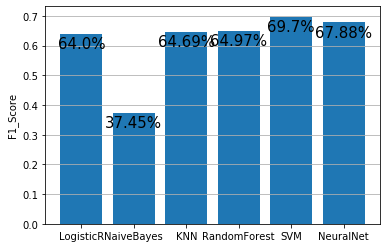

In [104]:
plt.bar(y_pos, f11+[f1_svm, f1_nn])
plt.xticks(y_pos, names+['SVM', 'NeuralNet'])
for y_v, f1_v in zip(y_pos, f11+[f1_svm, f1_nn]):
    plt.text(y_v, f1_v-0.05, str(np.around(f1_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('F1_Score')
plt.grid(axis='y')
plt.savefig('F1_score_1_NN.png')

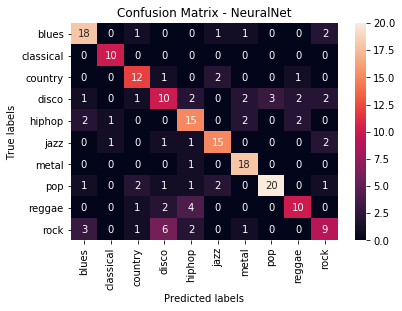

In [107]:
cm = confusion_matrix(y_test, pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, xticklabels=genres, yticklabels=genres)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix - NeuralNet')
plt.savefig('CM_1_NN.png', bbox_inches='tight')
plt.show()

In [108]:
svc = SVC(random_state=1)
param = {'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}
clf = GridSearchCV(svc, param, scoring = ['accuracy', 'f1_weighted'], refit = 'f1_weighted')
result = clf.fit(X_train, y_train)

In [109]:
print(result.best_score_)
print(result.best_params_)

0.6350558075117376
{'C': 10, 'kernel': 'linear'}


In [110]:
select_f1 = RFECV(SVC(kernel='linear', C=10), scoring='f1_weighted')
features = select_f1.fit_transform(X_train, y_train)

In [111]:
print(select_f1.n_features_)
print(select_f1.ranking_)

21
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [121]:
select_acc = RFECV(SVC(kernel='linear', C=10), scoring='accuracy')
features = select_acc.fit_transform(X_train, y_train)

In [122]:
print(select_acc.n_features_)
print(select_acc.ranking_)

21
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [64]:
# Доколку е потребно да се отстранат карактеристики

y3_train = y_train
y3_test = y_test
X3_train = np.array([X_train[:, i] for i, f in enumerate(select_f1.ranking_) if f==1]).T
X3_test = np.array([X_test[:, i] for i, f in enumerate(select_f1.ranking_) if f==1]).T

svc = SVC(random_state=rand)
param = [{'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}, 
         {'kernel': ['rbf'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000], 
         'gamma': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]}]
clf = GridSearchCV(svc, param, scoring = ['accuracy', 'f1_weighted'], refit = 'f1_weighted')
result = clf.fit(X3_train, y3_train)

print(result.best_score_)
print(result.best_params_)

pred = clf.predict(X3_test)
acc = accuracy_score(y3_test, pred)
f1 = f1_score(y3_test, pred, average='weighted')
print(acc)
print(f1)
print(confusion_matrix(y3_test, pred))

c:\users\hp\venv\iktim\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\m

c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classificat

c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classificat

c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classificat

c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classificat

In [179]:
list1 = []
list2 = []
list3 = []
list4 = []
list5 = []
list6 = []
list7 = []
new_features_names = ['chroma_cqt', 'chroma_cens', 'melspec', 'spectral_flatness',
                'poly_features', 'tonnetz', 'tempgr']
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for g in genres:
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        list1.append(np.mean(librosa.feature.chroma_cqt(y=y, sr=sr)))
        list2.append(np.mean(librosa.feature.chroma_cens(y=y, sr=sr)))
        list3.append(np.mean(librosa.feature.melspectrogram(y=y, sr=sr)))
        list4.append(np.mean(librosa.feature.spectral_flatness(y=y)))
        list5.append(np.mean(librosa.feature.poly_features(y=y, sr=sr)))
        list6.append(np.mean(librosa.feature.tonnetz(y=y, sr=sr)))
        list7.append(np.mean(librosa.feature.tempogram(y=y, sr=sr)))
        
file = open('genres2.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(new_features_names)
    
for i in np.arange(len(list1)):
    file = open('genres2.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow([list1[i], list2[i], list3[i], list4[i], list5[i], list6[i], list7[i]])

In [114]:
data2 = pd.read_csv('genres2.csv')
data2

,chroma_cqt,chroma_cens,melspec,spectral_flatness,poly_features,tonnetz,tempgr
0,0.549554,0.273436,4.425311,0.004499,1.751873,0.001620,0.152716
1,0.503215,0.261366,2.653045,0.002294,1.034521,0.014103,0.118854
2,0.515355,0.267732,7.256842,0.002628,2.454359,0.015280,0.136798
3,0.400808,0.238640,6.214398,0.000953,1.244653,0.006361,0.111334
4,0.521289,0.266510,2.107707,0.003239,1.249837,-0.036906,0.133789
...,...,...,...,...,...,...,...
995,0.459528,0.247900,1.454363,0.006553,1.082813,-0.015828,0.159365
996,0.490521,0.252545,1.379705,0.006453,1.154876,-0.011207,0.190346
997,0.571382,0.268265,1.397198,0.007514,1.315227,0.003276,0.210908
998,0.457033,0.251991,1.891385,0.001715,0.901760,0.019149,0.185357


In [115]:
data3 = data.iloc[:, :-1]
data2_names = data2.columns
for i in data2_names:
    data3[i] = data2[i]
data3

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tempo,mfcc1,mfcc2,...,mfcc11,mfcc12,mfcc13,chroma_cqt,chroma_cens,melspec,spectral_flatness,poly_features,tonnetz,tempgr
0,0.349943,0.130225,1784.420446,2002.650192,20.530733,3806.485316,0.083066,123.046875,-113.596748,121.557297,...,-8.324325,8.810669,-3.667369,0.549554,0.273436,4.425311,0.004499,1.751873,0.001620,0.152716
1,0.340983,0.095918,1529.835316,2038.617579,20.676334,3548.820207,0.056044,107.666016,-207.556793,124.006721,...,-5.560388,5.376803,-2.239120,0.503215,0.261366,2.653045,0.002294,1.034521,0.014103,0.118854
2,0.363603,0.175573,1552.481958,1747.165985,22.197265,3040.514948,0.076301,161.499023,-90.754387,140.459915,...,-13.123111,5.789265,-8.905224,0.515355,0.267732,7.256842,0.002628,2.454359,0.015280,0.136798
3,0.404779,0.141191,1070.119953,1596.333948,21.428764,2185.028454,0.033309,172.265625,-199.431152,150.099213,...,-3.196314,6.087676,-2.476421,0.400808,0.238640,6.214398,0.000953,1.244653,0.006361,0.111334
4,0.308590,0.091563,1835.494603,1748.362448,21.467739,3580.945013,0.101500,135.999178,-160.266037,126.198807,...,-13.083821,-2.806384,-6.934123,0.521289,0.266510,2.107707,0.003239,1.249837,-0.036906,0.133789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.351991,0.079469,2008.581132,2106.617024,22.988721,4254.215942,0.089267,103.359375,-153.632309,109.857262,...,-12.380283,12.350817,-12.306271,0.459528,0.247900,1.454363,0.006553,1.082813,-0.015828,0.159365
996,0.398653,0.076452,2006.051164,2068.327905,22.673572,4147.374921,0.097659,117.453835,-142.424210,116.219780,...,-12.982494,14.065345,-16.394691,0.490521,0.252545,1.379705,0.006453,1.154876,-0.011207,0.190346
997,0.432103,0.081617,2077.190361,1926.989678,22.320874,4030.767293,0.121824,129.199219,-125.031311,115.194977,...,-16.048916,10.481961,-17.951916,0.571382,0.268265,1.397198,0.007514,1.315227,0.003276,0.210908
998,0.362349,0.083888,1398.672358,1818.148469,22.499462,3014.740104,0.048731,112.347147,-224.972305,123.656891,...,-9.000730,7.683083,-10.071787,0.457033,0.251991,1.891385,0.001715,0.901760,0.019149,0.185357


In [116]:
encoder = LabelEncoder()
y3 = encoder.fit_transform(genre_list)

scaler = StandardScaler()
X3 = scaler.fit_transform(np.array(data3, dtype = float))

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=rand)

print(X3_train.shape)
print(y3_test.shape)

(1000, 1)
(800, 28)
(200,)


c:\users\hp\venv\iktim\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
select2_acc = RFECV(SVC(kernel='linear', C=3), scoring='accuracy')
features2 = select2_acc.fit_transform(X3_train, y3_train)

In [124]:
print(select2_acc.n_features_)
print(select2_acc.ranking_)

27
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1]


In [125]:
select2_f1 = RFECV(SVC(kernel='linear', C=3), scoring='f1_weighted')
features2_f1 = select2_f1.fit_transform(X3_train, y3_train)

In [126]:
print(select2_f1.n_features_)
print(select2_f1.ranking_)

28
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [127]:
svc = SVC(random_state=rand)
param = [{'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}, 
         {'kernel': ['rbf'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000], 
         'gamma': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]}]
clf = GridSearchCV(svc, param, scoring = ['accuracy', 'f1_weighted'], refit = 'f1_weighted')
result2 = clf.fit(X3_train, y3_train)

In [128]:
print(result2.best_score_)
print(result2.best_params_)

0.6965050156957525
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [129]:
pred = clf.predict(X3_test)
acc = accuracy_score(y3_test, pred)
f1 = f1_score(y3_test, pred, average='weighted')
print(acc)
print(f1)
print(confusion_matrix(y3_test, pred))

0.715
0.7104440416893071
[[18  0  3  1  0  0  0  0  0  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 11  1  0  1  0  0  2  1]
 [ 2  0  1 11  6  0  1  0  1  1]
 [ 1  0  0  0 16  0  2  0  2  1]
 [ 1  1  1  0  0 16  0  0  0  1]
 [ 0  0  0  0  1  0 18  0  0  0]
 [ 0  0  1  0  1  2  0 23  0  1]
 [ 0  0  0  3  2  1  0  0 11  0]
 [ 3  0  2  2  2  0  4  0  0  9]]


In [157]:
clf = SVC(C=300, gamma=0.009, kernel='rbf', random_state=rand)
clf.fit(X3_train, y3_train)
pred_svm = clf.predict(X3_test)
acc_svm = accuracy_score(y3_test, pred_svm)
f1_svm = f1_score(y3_test, pred_svm, average='weighted')
print(acc_svm)
print(f1_svm)
print(confusion_matrix(y3_test, pred_svm))

0.745
0.7400688007602387
[[19  0  2  1  0  0  0  0  0  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 12  1  0  1  0  0  1  1]
 [ 0  0  2 12  4  0  0  0  2  3]
 [ 1  0  0  1 18  0  0  0  2  0]
 [ 1  3  0  0  0 15  0  0  0  1]
 [ 0  0  0  0  0  0 19  0  0  0]
 [ 0  0  2  2  0  1  0 22  0  1]
 [ 0  0  1  2  0  0  1  0 13  0]
 [ 2  0  1  2  3  1  2  1  1  9]]


In [177]:
model = Sequential()
model.add(layers.Dense(512, activation='tanh', input_shape=(X3_train.shape[1],)))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [178]:
history = model.fit(X3_train, y3_train, epochs=20, batch_size=20, validation_split=0.1)

Train on 720 samples, validate on 80 samples
Epoch 1/20
720/720 [==============================] - 1s 2ms/step - loss: 1.8079 - accuracy: 0.3681 - val_loss: 1.4790 - val_accuracy: 0.4625
Epoch 2/20
720/720 [==============================] - 0s 467us/step - loss: 1.2486 - accuracy: 0.5514 - val_loss: 1.3503 - val_accuracy: 0.4625
Epoch 3/20
720/720 [==============================] - 0s 474us/step - loss: 1.0286 - accuracy: 0.6417 - val_loss: 1.1683 - val_accuracy: 0.5250
Epoch 4/20
720/720 [==============================] - 0s 504us/step - loss: 0.9060 - accuracy: 0.7000 - val_loss: 1.1015 - val_accuracy: 0.6125
Epoch 5/20
720/720 [==============================] - 0s 506us/step - loss: 0.7996 - accuracy: 0.7208 - val_loss: 0.9302 - val_accuracy: 0.6875
Epoch 6/20
720/720 [==============================] - 0s 497us/step - loss: 0.7439 - accuracy: 0.7556 - val_loss: 0.9959 - val_accuracy: 0.6125
Epoch 7/20
720/720 [==============================] - 0s 519us/step - loss: 0.6573 - accuracy

In [179]:
result2 = model.evaluate(X3_test, y3_test)
print(result2)

200/200 [==============================] - 0s 150us/step
[1.2631027603149414, 0.7149999737739563]


In [180]:
predd = model.predict(X3_test)
pred = []
for p in predd:
    pred.append(np.argmax(p))
acc_nn = accuracy_score(y3_test, pred)
f1_nn = f1_score(y3_test, pred, average='weighted')
print(acc_nn)
print(f1_nn)
print(confusion_matrix(y3_test, pred))

0.715
0.7040445304253354
[[18  0  3  0  0  0  0  0  0  2]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 11  1  0  1  0  0  1  2]
 [ 1  0  1  9  4  0  1  3  1  3]
 [ 0  0  0  0 19  1  0  0  2  0]
 [ 0  1  1  0  2 15  0  0  0  1]
 [ 0  0  0  0  2  0 17  0  0  0]
 [ 0  1  1  0  1  1  0 23  0  1]
 [ 0  0  0  1  1  1  0  0 14  0]
 [ 4  0  1  3  3  0  2  1  1  7]]


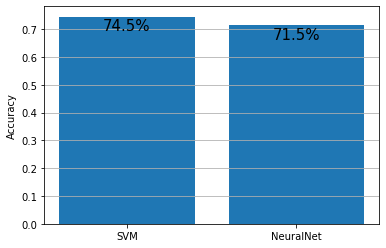

In [183]:
names2 = ['SVM', 'NeuralNet']
plt.bar([0, 1], [acc_svm, acc_nn])
plt.xticks([0, 1], names2)
for y_v, acc_v in zip([0, 1], [acc_svm, acc_nn]):
    plt.text(y_v, acc_v-0.05, str(np.around(acc_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.savefig('Accuracy_3_NN_svm.png')

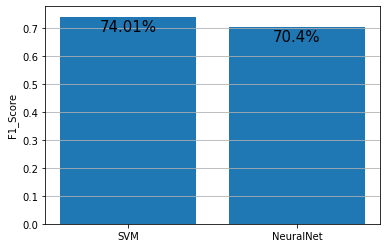

In [184]:
plt.bar([0, 1], [f1_svm, f1_nn])
plt.xticks([0, 1], names2)
for y_v, f1_v in zip([0, 1], [f1_svm, f1_nn]):
    plt.text(y_v, f1_v-0.05, str(np.around(f1_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('F1_Score')
plt.grid(axis='y')
plt.savefig('F1_score_3_NN_svm.png')

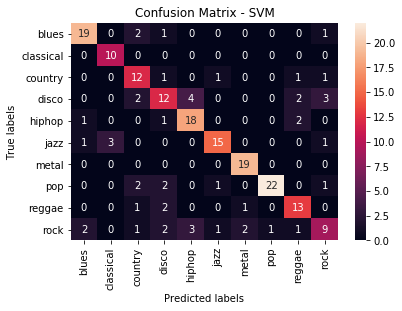

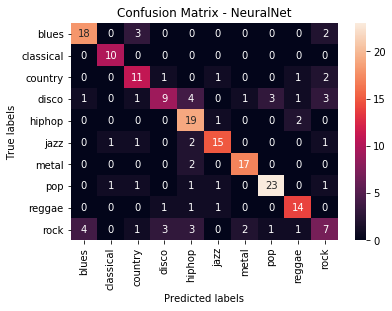

In [185]:
for i, pr in enumerate([pred_svm, pred]):
    cm = confusion_matrix(y_test, pr)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, xticklabels=genres, yticklabels=genres)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix - '+names2[i])
    plt.savefig('CM_3_'+names2[i]+'.png', bbox_inches='tight')
    plt.show()

In [282]:
other_mfccs = []
for i in range(14, 21):
    other_mfccs.append(f'mfcc{i}')
file = open('genres3.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(other_mfccs)

list1 = []
list2 = []
list3 = []
list4 = []
list5 = []
list6 = []
list7 = []
for g in genres:
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        for i, e in enumerate(mfcc):
            if i==13: 
                list1.append(np.mean(e))
            elif i ==14:
                list2.append(np.mean(e))
            elif i ==15:
                list3.append(np.mean(e))
            elif i ==16:
                list4.append(np.mean(e))
            elif i ==17:
                list5.append(np.mean(e))
            elif i ==18:
                list6.append(np.mean(e))
            elif i ==19:
                list7.append(np.mean(e))
        file = open('genres3.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow([list1[-1], list2[-1], list3[-1], list4[-1], 
                             list5[-1], list6[-1], list7[-1]])

In [186]:
data4 = pd.read_csv('genres3.csv')

data5 = data.iloc[:, :-1]
data4_names = data4.columns
for i in data4_names:
    data5[i] = data4[i]
    
data2_names = data2.columns
for i in data2_names:
    data5[i] = data2[i]
data5

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tempo,mfcc1,mfcc2,...,mfcc18,mfcc19,mfcc20,chroma_cqt,chroma_cens,melspec,spectral_flatness,poly_features,tonnetz,tempgr
0,0.349943,0.130225,1784.420446,2002.650192,20.530733,3806.485316,0.083066,123.046875,-113.596748,121.557297,...,-0.409953,-2.300209,1.219929,0.549554,0.273436,4.425311,0.004499,1.751873,0.001620,0.152716
1,0.340983,0.095918,1529.835316,2038.617579,20.676334,3548.820207,0.056044,107.666016,-207.556793,124.006721,...,0.293876,-0.287431,0.531574,0.503215,0.261366,2.653045,0.002294,1.034521,0.014103,0.118854
2,0.363603,0.175573,1552.481958,1747.165985,22.197265,3040.514948,0.076301,161.499023,-90.754387,140.459915,...,-1.815723,-3.433434,-2.226821,0.515355,0.267732,7.256842,0.002628,2.454359,0.015280,0.136798
3,0.404779,0.141191,1070.119953,1596.333948,21.428764,2185.028454,0.033309,172.265625,-199.431152,150.099213,...,0.637981,-0.619690,-3.408233,0.400808,0.238640,6.214398,0.000953,1.244653,0.006361,0.111334
4,0.308590,0.091563,1835.494603,1748.362448,21.467739,3580.945013,0.101500,135.999178,-160.266037,126.198807,...,-0.924161,-4.409333,-11.703780,0.521289,0.266510,2.107707,0.003239,1.249837,-0.036906,0.133789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.351991,0.079469,2008.581132,2106.617024,22.988721,4254.215942,0.089267,103.359375,-153.632309,109.857262,...,2.473193,-6.717574,-1.189237,0.459528,0.247900,1.454363,0.006553,1.082813,-0.015828,0.159365
996,0.398653,0.076452,2006.051164,2068.327905,22.673572,4147.374921,0.097659,117.453835,-142.424210,116.219780,...,1.875218,-7.459579,-2.802676,0.490521,0.252545,1.379705,0.006453,1.154876,-0.011207,0.190346
997,0.432103,0.081617,2077.190361,1926.989678,22.320874,4030.767293,0.121824,129.199219,-125.031311,115.194977,...,3.447424,-12.594178,-2.107002,0.571382,0.268265,1.397198,0.007514,1.315227,0.003276,0.210908
998,0.362349,0.083888,1398.672358,1818.148469,22.499462,3014.740104,0.048731,112.347147,-224.972305,123.656891,...,1.558265,-5.043121,-3.585595,0.457033,0.251991,1.891385,0.001715,0.901760,0.019149,0.185357


In [187]:
encoder = LabelEncoder()
y4 = encoder.fit_transform(genre_list)

scaler = StandardScaler()
X4 = scaler.fit_transform(np.array(data5, dtype = float))

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=rand)

print(X4_train.shape)
print(y4_test.shape)

(1000, 1)
(800, 35)
(200,)


c:\users\hp\venv\iktim\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [188]:
svc = SVC(random_state=rand)
param = [{'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}]
clf = GridSearchCV(svc, param, scoring = ['accuracy', 'f1_weighted'], refit = 'f1_weighted')
result3 = clf.fit(X4_train, y4_train)

In [189]:
print(result3.best_score_)
print(result3.best_params_)

0.6735204490103766
{'C': 0.3, 'kernel': 'linear'}


In [190]:
select3_acc = RFECV(SVC(kernel='linear', C=0.3), scoring='accuracy')
features3 = select3_acc.fit_transform(X4_train, y4_train)

In [191]:
print(select3_acc.n_features_)
print(select3_acc.ranking_)

35
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [192]:
select3_f1 = RFECV(SVC(kernel='linear', C=0.3), scoring='f1_weighted')
features3 = select3_f1.fit_transform(X4_train, y4_train)

In [193]:
print(select3_f1.n_features_)
print(select3_f1.ranking_)

35
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [194]:
svc = SVC(random_state=rand)
param = [{'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}, 
         {'kernel': ['rbf'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000], 
         'gamma': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]},]
clf = GridSearchCV(svc, param, scoring = ['accuracy', 'f1_weighted'], refit = 'f1_weighted')
result3 = clf.fit(X4_train, y4_train)

In [195]:
print(result3.best_score_)
print(result3.best_params_)

0.6900508146664134
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [196]:
pred = clf.predict(X4_test)
acc = accuracy_score(y4_test, pred)
f1 = f1_score(y4_test, pred, average='weighted')
print(acc)
print(f1)
print(confusion_matrix(y4_test, pred))

0.715
0.710272026574658
[[18  0  2  1  0  1  0  0  0  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  1  0  0  0  0  2  3]
 [ 0  0  3 13  5  0  0  0  0  2]
 [ 0  0  0  0 17  0  1  0  3  1]
 [ 0  2  1  1  0 15  0  0  1  0]
 [ 0  0  0  0  0  0 19  0  0  0]
 [ 0  0  2  1  0  0  0 23  0  2]
 [ 0  0  0  2  2  1  0  0 12  0]
 [ 4  0  4  2  2  0  3  1  0  6]]


In [206]:
clf = SVC(C=20, gamma=0.04, kernel='rbf', random_state=rand)
clf.fit(X4_train, y4_train)
pred_svm = clf.predict(X4_test)
acc_svm = accuracy_score(y4_test, pred_svm)
f1_svm = f1_score(y4_test, pred_svm, average='weighted')
print(acc_svm)
print(f1_svm)
print(confusion_matrix(y4_test, pred_svm))

0.745
0.7444421641421641
[[17  0  4  1  0  0  0  0  0  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 11  1  0  0  0  1  2  1]
 [ 0  0  1 13  5  0  0  0  1  3]
 [ 1  0  0  1 17  0  1  0  2  0]
 [ 1  1  0  0  1 16  0  0  0  1]
 [ 1  0  0  0  0  0 18  0  0  0]
 [ 0  0  2  0  1  0  0 23  0  2]
 [ 0  0  0  1  1  1  0  0 14  0]
 [ 3  0  2  2  3  0  2  0  0 10]]


In [216]:
model = Sequential()
model.add(layers.Dense(512, activation='tanh', input_shape=(X4_train.shape[1],)))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [217]:
history = model.fit(X4_train, y4_train, epochs=20, batch_size=20, validation_split=0.1)

Train on 720 samples, validate on 80 samples
Epoch 1/20
720/720 [==============================] - 1s 2ms/step - loss: 1.7830 - accuracy: 0.3583 - val_loss: 1.3382 - val_accuracy: 0.5000
Epoch 2/20
720/720 [==============================] - 0s 561us/step - loss: 1.2195 - accuracy: 0.5875 - val_loss: 1.2061 - val_accuracy: 0.5375
Epoch 3/20
720/720 [==============================] - 0s 554us/step - loss: 0.9600 - accuracy: 0.6792 - val_loss: 1.1427 - val_accuracy: 0.5625
Epoch 4/20
720/720 [==============================] - 0s 578us/step - loss: 0.8388 - accuracy: 0.7014 - val_loss: 1.0610 - val_accuracy: 0.6000
Epoch 5/20
720/720 [==============================] - 0s 540us/step - loss: 0.6963 - accuracy: 0.7639 - val_loss: 0.9250 - val_accuracy: 0.6000
Epoch 6/20
720/720 [==============================] - 0s 514us/step - loss: 0.5751 - accuracy: 0.8181 - val_loss: 0.9888 - val_accuracy: 0.6500
Epoch 7/20
720/720 [==============================] - 0s 568us/step - loss: 0.5227 - accuracy

In [218]:
result3 = model.evaluate(X4_test, y4_test)
print(result3)

200/200 [==============================] - 0s 195us/step
[1.1720624017715453, 0.7350000143051147]


In [219]:
predd = model.predict(X4_test)
pred = []
for p in predd:
    pred.append(np.argmax(p))
acc_nn = accuracy_score(y4_test, pred)
f1_nn = f1_score(y4_test, pred, average='weighted')
print(acc_nn)
print(f1_nn)
print(confusion_matrix(y4_test, pred))

0.735
0.7260560867747539
[[17  0  2  0  0  1  1  0  1  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  2  0  1  0  0  2  1]
 [ 0  0  1 15  3  0  0  1  2  1]
 [ 0  0  0  2 14  1  1  1  3  0]
 [ 0  1  0  1  0 17  0  0  1  0]
 [ 0  0  0  0  1  0 18  0  0  0]
 [ 1  0  1  0  0  0  0 25  0  1]
 [ 0  0  0  1  1  1  0  0 14  0]
 [ 2  0  3  3  0  0  3  2  2  7]]


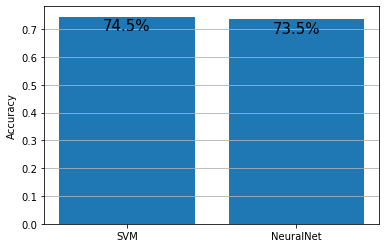

In [220]:
plt.bar([0, 1], [acc_svm, acc_nn])
plt.xticks([0, 1], names2)
for y_v, acc_v in zip([0, 1], [acc_svm, acc_nn]):
    plt.text(y_v, acc_v-0.05, str(np.around(acc_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.savefig('Accuracy_4_NN_svm.png')

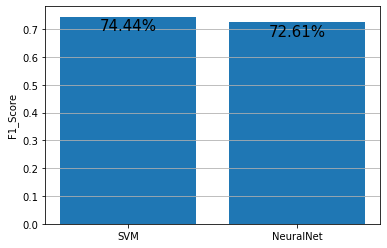

In [221]:
plt.bar([0, 1], [f1_svm, f1_nn])
plt.xticks([0, 1], names2)
for y_v, f1_v in zip([0, 1], [f1_svm, f1_nn]):
    plt.text(y_v, f1_v-0.05, str(np.around(f1_v*100, 2))+'%', horizontalalignment='center', fontsize=15)
plt.ylabel('F1_Score')
plt.grid(axis='y')
plt.savefig('F1_score_4_NN_svm.png')

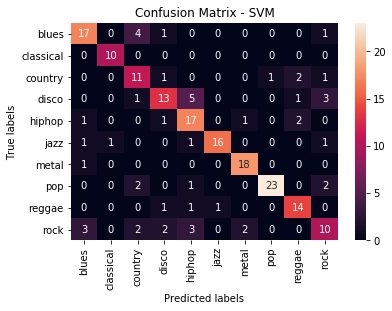

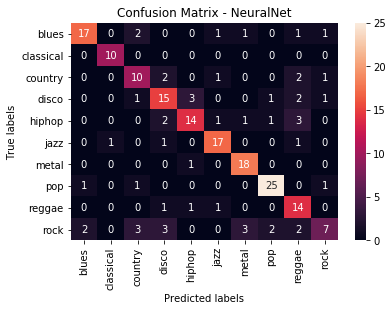

In [222]:
for i, pr in enumerate([pred_svm, pred]):
    cm = confusion_matrix(y_test, pr)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, xticklabels=genres, yticklabels=genres)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix - '+names2[i])
    plt.savefig('CM_4_'+names2[i]+'.png', bbox_inches='tight')
    plt.show()

In [226]:
data6 = pd.DataFrame()
for name in data5.columns:
    if 'mfcc' in name:
        data6[name] = data5[name]
        
data6

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,-113.596748,121.557297,-19.158827,42.351028,-6.376458,18.618876,-13.697912,15.344631,-12.285267,10.980493,-8.324325,8.810669,-3.667369,5.751690,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929
1,-207.556793,124.006721,8.930560,35.874683,2.916037,21.523726,-8.554704,23.358671,-10.103617,11.903745,-5.560388,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531574
2,-90.754387,140.459915,-29.109964,31.689013,-13.987036,25.754759,-13.649587,11.629271,-11.780589,9.706443,-13.123111,5.789265,-8.905224,-1.083720,-9.218359,2.455807,-7.726901,-1.815723,-3.433434,-2.226821
3,-199.431152,150.099213,5.647593,26.871925,1.754462,14.238345,-4.830883,9.297966,-0.757742,8.149013,-3.196314,6.087676,-2.476421,-1.073891,-2.874778,0.780977,-3.316932,0.637981,-0.619690,-3.408233
4,-160.266037,126.198807,-35.605450,22.153301,-32.489265,10.864513,-23.357929,0.503118,-11.805832,1.206806,-13.083821,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-153.632309,109.857262,-23.085709,59.040672,-7.490499,19.731216,-16.481268,18.078421,-22.209015,15.402502,-12.380283,12.350817,-12.306271,5.780973,-10.279924,1.791490,-13.304210,2.473193,-6.717574,-1.189237
996,-142.424210,116.219780,-32.177074,49.122971,-8.375370,22.869041,-18.311548,20.091076,-22.100393,10.800343,-12.982494,14.065345,-16.394691,4.152588,-4.350760,3.736456,-10.845638,1.875218,-7.459579,-2.802676
997,-125.031311,115.194977,-47.993507,52.834530,-13.480977,21.755636,-12.418756,20.130630,-18.361841,10.113328,-16.048916,10.481961,-17.951916,1.211113,-11.534864,1.844774,-12.847901,3.447424,-12.594178,-2.107002
998,-224.972305,123.656891,-9.754534,56.595062,10.443339,20.611948,-10.250206,15.563110,-8.238567,12.796228,-9.000730,7.683083,-10.071787,-0.255098,-5.276486,-2.816288,-4.416438,1.558265,-5.043121,-3.585595


In [227]:
encoder = LabelEncoder()
y6 = encoder.fit_transform(genre_list)

scaler = StandardScaler()
X6 = scaler.fit_transform(np.array(data6, dtype = float))

X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2, random_state=rand)

print(X6_train.shape)
print(y6_test.shape)

(800, 20)
(200,)


c:\users\hp\venv\iktim\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [228]:
svc = SVC(random_state=rand)
param = [{'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}, 
         {'kernel': ['rbf'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000], 
         'gamma': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]},]
clf = GridSearchCV(svc, param, scoring = ['accuracy', 'f1_weighted'], refit = 'f1_weighted')
result4 = clf.fit(X6_train, y6_train)

In [229]:
print(result4.best_score_)
print(result4.best_params_)

0.6184736808580622
{'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}


In [231]:
pred = clf.predict(X6_test)
acc = accuracy_score(y6_test, pred)
f1 = f1_score(y6_test, pred, average='weighted')
print(acc)
print(f1)
print(confusion_matrix(y6_test, pred))

0.62
0.6193155360361563
[[13  0  5  1  0  1  2  0  0  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  0  7  1  0  2  0  2  2  1]
 [ 0  0  3 11  7  0  0  1  1  0]
 [ 0  0  1  1 12  2  2  0  2  2]
 [ 1  2  0  0  4 12  0  0  0  1]
 [ 0  0  0  0  0  0 19  0  0  0]
 [ 0  0  2  0  2  0  0 22  1  1]
 [ 0  0  0  1  4  2  0  0 10  0]
 [ 2  0  4  3  1  1  2  0  1  8]]


In [245]:
clf = SVC(C=2, gamma=0.07, kernel='rbf', random_state=rand)
clf.fit(X6_train, y6_train)
pred_svm = clf.predict(X6_test)
acc_svm = accuracy_score(y6_test, pred_svm)
f1_svm = f1_score(y6_test, pred_svm, average='weighted')
print(acc_svm)
print(f1_svm)
print(confusion_matrix(y6_test, pred_svm))

0.65
0.6475792634211204
[[13  0  2  1  0  2  2  0  0  3]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  0  9  1  0  2  0  0  2  1]
 [ 0  0  2 11  8  0  0  1  1  0]
 [ 0  0  0  1 14  2  2  0  2  1]
 [ 1  1  0  1  3 13  0  0  0  1]
 [ 0  0  0  0  1  0 18  0  0  0]
 [ 0  0  1  0  1  0  0 23  1  2]
 [ 0  0  0  1  3  2  0  0 11  0]
 [ 2  0  3  3  1  1  3  0  1  8]]


In [249]:
model = Sequential()
model.add(layers.Dense(512, activation='tanh', input_shape=(X6_train.shape[1],)))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [250]:
history = model.fit(X6_train, y6_train, epochs=20, batch_size=20, validation_split=0.1)

Train on 720 samples, validate on 80 samples
Epoch 1/20
720/720 [==============================] - 2s 2ms/step - loss: 1.9030 - accuracy: 0.3208 - val_loss: 1.5681 - val_accuracy: 0.4625
Epoch 2/20
720/720 [==============================] - 0s 553us/step - loss: 1.4088 - accuracy: 0.4903 - val_loss: 1.4105 - val_accuracy: 0.4750
Epoch 3/20
720/720 [==============================] - 0s 635us/step - loss: 1.2036 - accuracy: 0.5778 - val_loss: 1.3710 - val_accuracy: 0.5000
Epoch 4/20
720/720 [==============================] - 0s 500us/step - loss: 1.0616 - accuracy: 0.6194 - val_loss: 1.2904 - val_accuracy: 0.5500
Epoch 5/20
720/720 [==============================] - 0s 556us/step - loss: 0.9744 - accuracy: 0.6375 - val_loss: 1.2932 - val_accuracy: 0.6000
Epoch 6/20
720/720 [==============================] - 0s 639us/step - loss: 0.8983 - accuracy: 0.6778 - val_loss: 1.4212 - val_accuracy: 0.5875
Epoch 7/20
720/720 [==============================] - 0s 590us/step - loss: 0.8203 - accuracy

In [251]:
result4 = model.evaluate(X6_test, y6_test)
print(result4)

200/200 [==============================] - 0s 225us/step
[1.5224143481254577, 0.625]


In [150]:
# Доколку треба да се отстранат карактеристики

y5_train = y4_train
y5_test = y4_test
X5_train = np.array([X4_train[:, i] for i, f in enumerate(select3_f1.ranking_) if f==1]).T
X5_test = np.array([X4_test[:, i] for i, f in enumerate(select3_f1.ranking_) if f==1]).T

svc = SVC(random_state=rand)
param = [{'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}, 
         {'kernel': ['rbf'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000], 
         'gamma': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]}]
clf = GridSearchCV(svc, param, scoring = ['accuracy', 'f1_weighted'], refit = 'f1_weighted')
result4 = clf.fit(X5_train, y5_train)

print(result4.best_score_)
print(result4.best_params_)

pred = clf.predict(X5_test)
acc = accuracy_score(y5_test, pred)
f1 = f1_score(y5_test, pred, average='weighted')
print(acc)
print(f1)
print(confusion_matrix(y5_test, pred))

clf = SVC(C=1000, gamma=0.004, kernel='rbf', random_state=rand)
clf.fit(X5_train, y5_train)
pred_svm = clf.predict(X5_test)
acc_svm = accuracy_score(y5_test, pred_svm)
f1_svm = f1_score(y5_test, pred_svm, average='weighted')
print(acc_svm)
print(f1_svm)
print(confusion_matrix(y5_test, pred_svm))

model = Sequential()
model.add(layers.Dense(512, activation='tanh', input_shape=(X5_train.shape[1],)))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256, activation='tanh'))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X5_train, y5_train, epochs=20, batch_size=20, validation_split=0.1)

result4 = model.evaluate(X5_test, y5_test)
print(result4)

c:\users\hp\venv\iktim\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\m

c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classificat

c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classificat

c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classificat

c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\hp\venv\iktim\lib\site-packages\sklearn\metrics\classificat